NGD_SMB_with_gain_control  
Remember to put OU_best.npy and NGD_function.py into the same directory  
Note that it takes long time to run this code   
To reduce time, you can decrease cutoff frequncy or time step


In [1]:
#u is cone
#z is horizontal
#v is bipolar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
from NGD_function import *
%matplotlib inline

In [3]:
xlen = 2000#spatial extend of simulation
dxc = 20/xlen
sigma_zu = int(2/dxc)#sigma_zu is horizontal cell receptive field
sigma_v = sigma_zu*0.9#sigma_v is bipolar cell receptive field
sigma_zv = sigma_zu/5#sigma_zv is horizontal to bipolar cell receptive field size
Dynamical_range = 3*sigma_zu# Moving bar range

##Spatial kernal for horizontal cell
klen = int(sigma_zu*3)
xx = np.arange(0,klen)
khxs = K(xx,sigma_zu)
KH = np.zeros(klen*2-1)
tmp = khxs[::-1]
KH[0:klen]= tmp[0:klen]/dxc
KH[klen:2*klen]=khxs[1:klen]/dxc

##Spatial kernal for bipolar cell
klen = int(sigma_v*3)
xx = np.arange(0,klen)
kvxs = K(xx,sigma_v)
KV = np.zeros(klen*2-1)
tmp = kvxs[::-1]
KV[0:klen]= tmp[0:klen]/dxc
KV[klen:2*klen]=kvxs[1:klen]/dxc

##Spatial kernal for RF
klen = int(xlen/2)
xx = np.arange(0,klen)
kvxs = K(xx,sigma_v)
KRF = np.zeros(klen*2)
tmp = kvxs[::-1]
KRF[0:klen]= tmp[0:klen]/dxc
KRF[klen:2*klen]=kvxs[0:klen]/dxc

In [4]:
#Feedback filter for u
tau = 0.23#sec
feedback_filter = np.exp(-np.arange(0,1+0.01,0.01)/tau)

In [5]:
hw = int(sigma_zu*18/22)#half of width
pos_0 = int(xlen/2)#initial position
pos = pos_0
nstep = 50000
tau_u = 40#time constant of cone
tau_z = 2.#time constant of horizontal
tau_v = 100#time constant of bipolar
k = 40#Tune stimulus input and horizontal feedback
g = 2#Tune horizontal cell
psy = 0.5
p = 100
phi = 5

B = 300
order = 4#Order of gain control

total_frequency =[0.5,1,2,4]#[0.5]
dms = np.arange(-199,200)
#dms = np.arange(-99,100)
total_mi_ss = np.zeros([len(total_frequency),len(dms)])
total_mi_su = np.zeros([len(total_frequency),len(dms)])
total_mi_sv = np.zeros([len(total_frequency),len(dms)])
total_mi_svv = np.zeros([len(total_frequency),len(dms)])
total_mi_suu = np.zeros([len(total_frequency),len(dms)])

total_mi_scr = np.zeros([len(total_frequency),len(dms)])
total_mi_RF = np.zeros([len(total_frequency),len(dms)])
total_vv = np.zeros([len(total_frequency),nstep])
total_uu = np.zeros([len(total_frequency),nstep])
total_x = np.zeros([len(total_frequency),nstep])
total_velocity = np.zeros([len(total_frequency),nstep])
total_intensity = np.zeros([len(total_frequency),nstep])
total_speak = np.zeros([len(total_frequency),nstep])
total_upeak = np.zeros([len(total_frequency),nstep])
total_vpeak = np.zeros([len(total_frequency),nstep])

In [6]:
dt = 0.01
tau= 1
D = 27*10**5
mu, sigma = 0,1
Tot = nstep*dt

T=np.arange(dt,Tot+dt,dt)
#OU=np.zeros(nstep)
#for i in range(nstep-1):
#    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
OU = np.load('OU_best.npy')
for o in range(len(total_frequency)):
    print(o)
    xx = np.arange(0,xlen)
    u = np.zeros(xlen)#cone
    z = np.zeros(xlen)#horizontal cell
    v = np.zeros(xlen)#bipolar cell
    intensitys = np.zeros(nstep)
    speak = np.zeros(nstep)
    upeak = np.zeros(nstep)
    vpeak = np.zeros(nstep)
    total_u = np.zeros([int(xlen),nstep])#total cones
    total_v = np.zeros([int(xlen),nstep])#total bipolar cells
    total_rzv = np.zeros([int(xlen),nstep])#total horizontal feedforward inhibition to bipolar
    total_ruv = np.zeros([int(xlen),nstep])#total horizontal feedback inhibition to cone
    zts = np.zeros([int(xlen),nstep])#horizontal
    ss = np.zeros([int(xlen),nstep])#bar
    gains = np.zeros([int(xlen),nstep])#gain number
    
    #LPOU
    cutoffFreq = total_frequency[o]
    b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
    LPOU = signal.filtfilt(b, a, OU)
    trajectory = (LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*Dynamical_range
    trajectory = trajectory-np.mean(trajectory)
    
    for i in range(nstep):
        pos = pos_0+trajectory[i]
        speak[i] = pos
        s = np.zeros(xlen)#stimulus
        s[int(pos)-hw:int(pos)+hw] = 1
        intensity = np.convolve(s,KRF,'valid')
        intensitys[i] = intensity
        if i >=len(feedback_filter):#Check the array is longer enough (must longer than feedback filter)
            ru = np.convolve(u,KH,'same')*dxc # feedback from horizontal cell
            ruv = np.convolve(u,KV,'same')*dxc # input from cone
            for j in range(int(xlen)):
                ####Gain control######
                V = np.convolve(feedback_filter,total_v[j,i-len(feedback_filter)+1:i+1],'valid')*dt#average by expotential filtering
                g = gain(V,order,B)#Gain control
                gains[j,i] = g
                duj =(-tau_u*u[j]+k*(s[j]-phi*z[j]))*dt#Cone
                dzj =(-tau_z*z[j]+g*ru[j])*dt#horizontal
                dvj = (-tau_v*v[j]+p*((1-psy)*ruv[j]-psy*z[j]))*dt#bipolar
                u[j] = u[j]+duj
                z[j] = z[j]+dzj
                v[j] = v[j]+dvj
            v = v*gains[:,i]

        else:#Doesn't have gain control yet
            ru = np.convolve(u,KH,'same')*dxc # feedback from horizontal cell
            ruv = np.convolve(u,KV,'same')*dxc # input from cone
            duj =(-tau_u*u+k*(s-phi*z))*dt#Cone
            dzj =(-tau_z*z+g*ru)*dt#horizontal
            dvj = (-tau_v*v+p*((1-psy)*ruv-psy*z))*dt#bipolar
            u = u+duj
            z = z+dzj
            v = v+dvj
        
        maxpos = np.argmax(u)
        upeak[i]= maxpos
        maxpos = np.argmax(v)
        vpeak[i]= maxpos
        total_u[:,i] = u.copy()
        total_v[:,i] = v.copy()
        ss[:,i] = s
        zts[:,i] = z
        total_ruv[:,i] = ruv
    x = speak.copy()*dt
    x = x.astype(float)
    total_intensity[o,:] = intensitys.copy()
    total_x[o,:] = x.copy()
    vv = total_v[pos_0,:]
    uu = total_u[pos_0,:]
    total_vv[o,:] = vv
    total_uu[o,:] = uu
    total_speak[o,:] = speak
    total_vpeak[o,:] = vpeak
    total_upeak[o,:] = upeak

0
1
2
3


In [12]:
#Non-linear and calculate MI
window = [-2,2] #second
XOon = 2#1 is off cell, 2 is on cell
for j in range(len(total_frequency)):
    #Binning
    xstate, _= EqualState(total_x[j,:],6)
    
    ##Nonlinear---bipolar cells
    if XOon == 1:
        cr = NL(-np.mean(total_vv[j,:])+total_vv[j,:],0.0*np.std(total_vv[3,:]))#Off cell
    else:
        cr = NL(np.mean(total_vv[j,:])-total_vv[j,:],0.0*np.std(total_vv[3,:]))#On cell
    mi_scr = [mi_quick(total_speak[j,200:],cr[200:],d) for d in dms]#MI between position and bipolar cell voltage(nonlinear processing)
    mi_RF = [mi_quick(total_intensity[j,200:],cr[200:],d) for d in dms]#MI between intensity and bipolar cell voltage(nonlinear processing)
    
    mi_ss = [mi_quick(total_speak[j,200:],total_speak[j,200:],d) for d in dms]
    mi_su = [mi_quick(total_speak[j,200:],total_upeak[j,200:],d) for d in dms]
    mi_sv = [mi_quick(total_speak[j,200:],total_vpeak[j,200:],d) for d in dms]
    mi_svv = [mi_quick(total_speak[j,200:],total_vv[j,200:],d) for d in dms]#MI between position and bipolar cell voltage
    mi_suu = [mi_quick(total_speak[j,200:],total_uu[j,200:],d) for d in dms]#MI between position and cone voltage
    
    total_mi_ss[j,:] = mi_ss
    total_mi_su[j,:] = mi_su
    total_mi_sv[j,:] = mi_sv
    total_mi_svv[j,:] = mi_svv
    total_mi_scr[j,:] = mi_scr
    total_mi_RF[j,:] = mi_RF
    total_mi_suu[j,:] = mi_suu
    
    

bipolar 0.14
bipolar 0.11
bipolar 0.06
bipolar 0.03


Text(0.5, 1.0, 'MI between position and bipolar cell voltage')

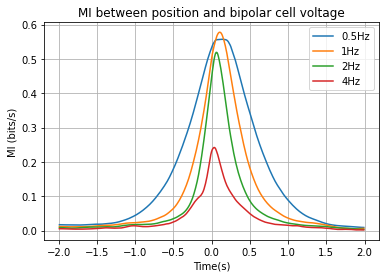

In [8]:
for i in range(len(total_frequency)):
    plt.plot(dms*dt,total_mi_svv[i,:],label=str(total_frequency[i])+'Hz')
    print('bipolar '+str(dms[np.argmax(total_mi_svv[i,:])]*dt))
plt.grid()
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('MI (bits/s)')
plt.title('MI between position and bipolar cell voltage')
#plt.savefig('different_frequency.jpg')

bipolar 0.15
bipolar 0.11
bipolar 0.08
bipolar 0.02


(-1.0, 1.5)

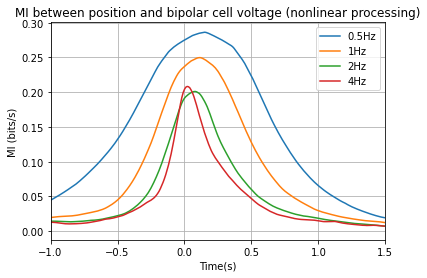

In [13]:
for i in range(len(total_frequency)):
    plt.plot(dms*dt,total_mi_scr[i,:],label=str(total_frequency[i])+'Hz')
    print('bipolar '+str(dms[np.argmax(total_mi_scr[i,:])]*dt))
plt.grid()
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('MI (bits/s)')
plt.title('MI between position and bipolar cell voltage (nonlinear processing)')
plt.xlim([-1.0,1.5])
#plt.savefig('non_different_frequency.jpg')